In [1]:
%matplotlib inline

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

ベイズ最適化の獲得関数のうち，有名なUCB(Upper Confidential Bound)もしくはEI(Expected Improvement)を使う．
この獲得関数を最大化して，なにするんだっけ？

ガウス過程回帰によって推定された分布（モデル）を使って，UCBを最大化する点をクロスエントロピー法で探索するプログラム

# ＴＭの研究におけるベイズ最適化の利用目的
できるだけ実験回数（データの数）を少なくして，所望の（ＵＣＢ最大）ｘを得る．
ＴＭのデータ収集において考えると，所望する「手先位置を固定したまま姿勢が変わるときの入力データｘ」を得る．そのために，ベイズ最適化をする．

In [2]:
def f(x):
    return x*np.sin(x)

def kernel(x, xd, param=[1,0.4,0.3]):
    return param[0]*np.exp(-(x - xd).T@(x - xd)/param[1]) + param[2]*(x == xd)
    
def gram_mtx(X, param=[1,0.4,0.3]):
    N_data = len(X)
    K = np.zeros((N_data, N_data))
    for i,j in product(range(N_data), range(N_data)):
        K[i,j] = kernel(X[i], X[j], param)

    return K

# ライブラリで作ったカーネル関数
kernelstd = 10
lib_kernel = C(1.0, (1e-3, 1e3)) * RBF(kernelstd, (1e-5, 1e5))
# standard deviation (std)
dy = 0.1 # the value for a potential numercal issue furing fitting by ensuring thatt calculated values from a positive definite matrix
#print(C(2.0, (1e-3, 1e3)))
#print(RBF(10))
# ガウス過程回帰のモデル
gp_func = GaussianProcessRegressor(kernel=lib_kernel, alpha=dy**2, n_restarts_optimizer=10)
print(gp_func)

def gep():
    pass

def gp_pred(x, gp=gp_func):
    mean, std = gp.predict(x, return_std=True)
    return mean, std

def UCB(x, f=gp_pred, beta=2.0): # Upper Confidence Bound # 獲得関数　# 信頼区間戦略
    mean, std = f(x)
    return mean + beta*std


def EI(): # 獲得関数 # 基本はUCBと共通している
    pass

GaussianProcessRegressor(alpha=0.010000000000000002,
                         kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=10)


In [3]:
UCB(np.linspace(-1, 10, 40).reshape(-1,1))

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2.])

In [4]:
# make training data
def y_func(x):
    return x*np.sin(x)

N_train = 6
X_train = np.random.uniform(0, 10, N_train)#.reshape(-1,1)    
X_train = np.atleast_2d(X_train).T
y_train = y_func(X_train)#.ravel()

X_test = np.linspace(0, 10, 100)
X_test = np.atleast_2d(X_test).T
y_test = y_func(X_test)
#print(y)
noize = np.random.normal(0,dy)
#y_train += noize
#print(y)

In [5]:
# fit gp model by x & y training data
#gp_pre = gp_func#.fit(X, y)
gp_func.fit(X_train,y_train)

GaussianProcessRegressor(alpha=0.010000000000000002,
                         kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=10)

学習されたガウス過程回帰のモデルに基づいて，UCBを最大化するxをCross Entropy法で見つける

(100, 1)
(100,)
(100,)


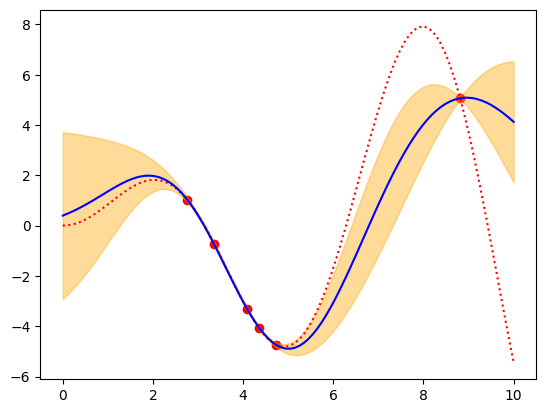

In [11]:
mean, std = gp_func.predict(X_test, return_std=True)

print(X_test.shape)
print(mean.shape)
print(std.shape)

plt.scatter(X_train, y_train, color='red')
plt.plot(X_test, y_test, color='red', linestyle='dotted') # predict
plt.plot(X_test, mean, color='blue') # true
plt.fill_between(X_test[:,0], mean+std, mean-std, alpha=0.4, color='orange')

In [22]:
# クロスエントロピー法で獲得関数UCBを最大化する
def Cem(objfunc, y_data, x_min=0, x_max=10, dim=1, iterMax=8, sampleNum=600, eliteNum=300):
    mean = None
    std = None
    sampleSet = None
    valueSet = None

    for i in range(iterMax):
        # 探索を始める範囲をx_min, x_maxで決める
        if i==0:
            sampleSet_i = np.random.uniform(x_min, x_max, sampleNum)
            #sampleSet_i = np.clip(sampleSet_i, x_min, x_max)  # なくても同じ？
        else:
            sampleSet_i = np.random.normal(loc=mean, scale=std, size=sampleNum)
            sampleSet_i = np.clip(sampleSet_i, x_min, x_max)

        # 得られたサンプルからエリートを選出する
        sampleSet = sampleSet_i.reshape((sampleNum, -1))
        #print(sampleSet.shape)
        valueSet = objfunc(sampleSet)
        #print(valueSet.shape)
        
        value_sort = np.sort(valueSet, axis=None)
        data_num = sampleSet.shape[0]
        v_cut = value_sort[data_num-eliteNum-1]
        #print(valueSet_elite.shape)
        elite_idx = (valueSet.flatten() > v_cut)
        #print(elite_idx)
        #print(sampleSet.shape)
        #print(elite_idx.shape)
        valueSet_elite = valueSet[elite_idx]
        #print(valueSet_elite.shape)
        sampleSet_elite = sampleSet[elite_idx,:]

        mean = np.mean(sampleSet_elite)
        std = np.std(sampleSet_elite)
        print(mean)

        # save list of mean and std
        sampleSet_list = list(sampleSet_elite)
        valueSet_list = list(valueSet_elite)
    
    return np.clip(mean, x_min, x_max)
        

In [23]:
# UCBをクロスエントロピー法で最大化
cem_mean = Cem(UCB, y_data=y_train, dim=len(y_train), x_min=0, x_max=10)
#print(mean)

5.728417304389369
6.819541450167914
8.356306294655306
9.384972248603002
9.881550912593024
9.97118353629438
9.99193974953613
9.99691599297698


これで，ガウス課程回帰のUCBが最大になった
分散が一番でかい（不確かさが最大）ところのデータを追加したら，ガウス課程回帰の予測精度を効率良く上げることができるはず！

(1000,)
(1000,)


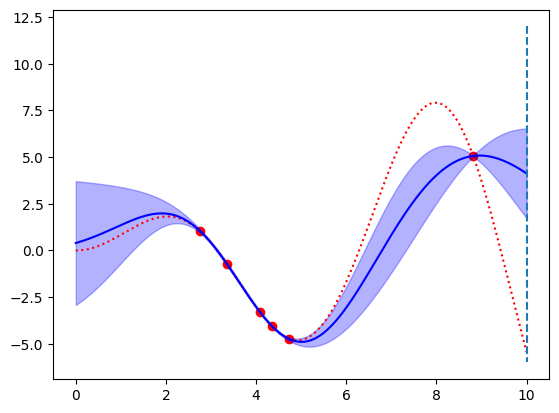

In [24]:
x = np.atleast_2d(np.linspace(0, 10, 1000)).T
y_mean, y_std = gp_func.predict(x, return_std=True)
print(y_mean.shape)
print(y_std.shape)

plt.figure()
plt.plot(x, y_func(x), color='red', linestyle='dotted')
plt.plot(x, y_mean, color='blue')
plt.scatter(X_train, y_train, color='r')
plt.fill_between(x[:,0], y_mean+y_std, y_mean-y_std, alpha=0.3, color='blue')

y_min, y_max = 12,-6
plt.vlines(cem_mean, y_min, y_max,linestyle='dashed')

分散or情報量が最大である入力ｘのデータを新しく追加し，ガウス課程回帰の予測モデルを改良する！

In [25]:
X_append = np.append(X_train, cem_mean)
X_append = np.atleast_2d(X_append).T

y_append = y_func(X_append).ravel()
noize_append = np.random.normal(0,dy)
y_append += noize_append
#print(y_append.shape)
#print(X_append.shape)

gp_func.fit(X_append, y_append)
gp_mean, gp_std = gp_func.predict(x, return_std=True)

In [26]:
cem_mean2 = Cem(UCB, y_append, dim=1, x_min=0, x_max=10)
print('mean = ', cem_mean2)

y_mean2, y_std2 = gp_func.predict(x, return_std=True)

4.875418367232781
4.55761134911356
4.179620892408881
3.2609527373173313
2.494935732920138
1.712557297429859
0.7132366397940149
0.1436954016344854
mean =  0.1436954016344854


In [27]:
print(X_train.shape)
print(X_append.shape)

(6, 1)
(7, 1)


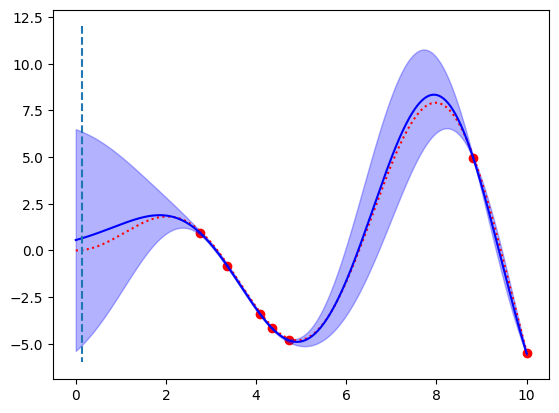

In [28]:
plt.figure()
plt.plot(x, y_func(x), color='red', linestyle='dotted')  # true
plt.plot(x, y_mean2, color='blue')  # predict
plt.scatter(X_append, y_append, color='r')
plt.fill_between(x[:,0], y_mean2+y_std2, y_mean2-y_std2, alpha=0.3, color='blue')

y_min, y_max = 12,-6
plt.vlines(cem_mean2, y_min, y_max,linestyle='dashed')

--- 新データ追加2回目 ----

In [35]:
X_append2 = np.append(X_append, cem_mean2)
X_append2 = np.atleast_2d(X_append2).T

y_append2 = y_func(X_append2).ravel()
noize_append = np.random.normal(0,dy)
y_append2 += noize_append
#print(y_append.shape)
#print(X_append.shape)

gp_func.fit(X_append2, y_append2)
gp_mean_ap2, gp_std_ap2 = gp_func.predict(x, return_std=True)

In [36]:
cem_mean3 = Cem(UCB, y_append2, dim=1, x_min=0, x_max=10)
print('mean = ', cem_mean3)

y_mean3, y_std3 = gp_func.predict(x, return_std=True)

5.643732581008989
6.2200549680277915
6.602991926912193
7.2811953880304445
7.49865222240447
7.587419330428062
7.58313845565066
7.584126060949137
mean =  7.584126060949137


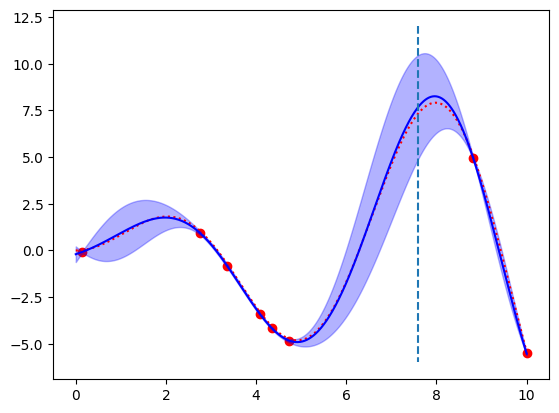

In [37]:
plt.figure()
plt.plot(x, y_func(x), color='red', linestyle='dotted')  # true
plt.plot(x, y_mean3, color='blue')  # predict
plt.scatter(X_append2, y_append2, color='r')
plt.fill_between(x[:,0], y_mean3+y_std3, y_mean3-y_std3, alpha=0.3, color='blue')

y_min, y_max = 12,-6
plt.vlines(cem_mean3, y_min, y_max,linestyle='dashed')